Created by:

Tomislav Tomov 6003618

Ioana Stoicescu 6003487  

## Introduction to ANN - PyTorch Exercise
---
Instructions are given in <span style="color:blue">blue</span> color.

## Overview
- [Task 1: Train a model for SVHN](#Task-1:-Train-a-model-for-SVHN)
  - [Task 1.1: Import helper functions](#Task-1.1:-Import-helper-functions)
  - [Task 1.2: Use SVHN](#Task-1.2:-Use-SVHN)
  - [Task 1.3: Create a model and use the appropriate device](#Task-1.3:-Create-a-model-and-use-the-appropriate-device)
  - [Task 1.4: Train the model](#Task-1.4:-Train-the-model)
  - [Task 1.5: Check model quality](#Task-1.5:-Check-model-quality)
- [Task 2: Use the model for inference](#Task-2:-Use-the-model-for-inference)
  - [Task 2.1: Inference and visualization](#Task-2.1:-Inference-and-visualization)
  - [Task 2.2: Challenge - visualizing misclassifications](#Task-2.2:-Challenge---visualizing-misclassifications)

---

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# for timing
import datetime as dt

## Task 1: Train a model for SVHN
In the first part of the exercise, we want to train a model we can use for `SVHN` and get an idea as to how well it performs, especially compared to the `scikit-learn` model.

### Task 1.1: Import helper functions
<span style="color:blue">
    In contrast to what we did in the material notebook, please use the helper functions for the training loop by importing them<br>
    <b>Hint:</b> The helper functions are provided in the script <code>train_loop.py</code>
</span>

In [8]:
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Task 1.2: Use SVHN
<span style="color:blue">
Instead of the MNIST dataset, use the SVHN dataset from the first exercise notebook: <a href=https://pytorch.org/vision/main/generated/torchvision.datasets.SVHN.html>SVHN</a>.<br>
    <b>Hint:</b> Like the MNIST dataset, <code>SVHN</code> is also directly available from the <code>torchvision.datasets</code> module. Although the parameters to load the data are slightly different!
</span>

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.SVHN(root="data", split="train", download=True, transform=transform)
test_data = datasets.SVHN(root="data", split="test", download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

100%|██████████████████████████████████████████████████████████████████████████████| 182M/182M [01:59<00:00, 1.52MB/s]


100%|████████████████████████████████████████████████████████████████████████████| 64.3M/64.3M [00:33<00:00, 1.92MB/s]


We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [12]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True) 
test_dataloader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle= False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of y: torch.Size([64]) torch.int64


--------------




### Task 1.3: Create a model and use the appropriate device
<span style="color:blue">
Make sure you create a neural network and use powerful hardware if available. Do you have to modify anything compared with the material notebook here? (Hint: color channel!)
</span>

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")   # checking if i can use GPU

Using device: cpu


In [111]:
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.flatten = nn.Flatten()  
        self.fc1 = nn.Linear(3 * 32 * 32, 128)  
        self.fc2 = nn.Linear(128, 64)          
        self.fc3 = nn.Linear(64, 10)           

    def forward(self, x):
        x = self.flatten(x)         
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x)) 
        x = self.fc3(x)             
        return x
    


In [113]:
USE_GPU = True

model = SimpleANN().to(device)
print(model)

dummy_images = torch.randn(64, 3, 32, 32).to(device)

dummy_output = model(dummy_images)
print(f"Output shape: {dummy_output.shape}")


SimpleANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Output shape: torch.Size([64, 10])


--------------




### Task 1.4: Train the model
<span style="color:blue">
    Now train the model for 10 epochs as in the MNIST case. Be sure to specify a <code>criterion</code> and an <code>optimizer</code> and record
    the time needed for training.
</span>

**Hint:** You need to adapt the learning rate of your optimizer to achieve a decent performance on this dataset!

In [143]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
model.add_module("dropout", nn.Dropout(p=0.5))



In [145]:
# helper function
def train(device, model, dataloader, optimizer, criterion, binary=True, unsqueeze=False):
    model.train() 
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Iterate over the training dataset
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        if unsqueeze:
            labels=labels.unsqueeze(1).float()
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
         # Compute the predicted labels
        if binary:
            predicted = torch.round(outputs)
        else:
            outputs = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        # Count correct and total predictions
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        

    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    return epoch_loss, epoch_accuracy

In [147]:
def validate(device, model, dataloader, criterion, binary=True, unsqueeze=False):
    running_loss_val = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
     # Set the model to validation mode
    model.eval() 
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over validation set
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            if unsqueeze:
                labels=labels.unsqueeze(1).float()
            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            running_loss_val += loss.item()

            # Compute the predicted labels
            if binary:
                predicted = torch.round(outputs)
            else:
                outputs = torch.softmax(outputs, 1)
                _, predicted = torch.max(outputs, 1)
            # Count correct and total predictions
            total_predictions_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()
            
    # Calculate the average loss and accuracy
    epoch_loss_val = running_loss_val / len(dataloader)
    epoch_accuracy_val = (correct_predictions_val / total_predictions_val) * 100
    return epoch_loss_val, epoch_accuracy_val

In [149]:
def train_for_epochs(device, epchs, model, trainloader, valloader, optimizer, criterion, binary=True, unsqueeze=False):
    # dictionary for saving history during training
    history = {
        "train": {
            "loss": [],
            "accuracy": []
        },
        "val": {
            "loss": [],
            "accuracy": []
        }
    }
    loop = trange(epchs) # a nice way to display progress using a widget
    # Training loop
    for epoch in loop:

        epoch_loss_train, epoch_accuracy_train = train(device, model, trainloader, optimizer, criterion, binary=binary, unsqueeze=unsqueeze)   

        history["train"]["loss"].append(epoch_loss_train)
        history["train"]["accuracy"].append(epoch_accuracy_train)

        epoch_loss_val, epoch_accuracy_val = validate(device, model, valloader, criterion, binary=binary, unsqueeze=unsqueeze)   

        history["val"]["loss"].append(epoch_loss_val)
        history["val"]["accuracy"].append(epoch_accuracy_val)

        loop.set_description(f"Train Loss: {epoch_loss_train:.2f}, Train Acc: {epoch_accuracy_train:.2f}, Val Loss: {epoch_loss_val:.2f}, Val Acc: {epoch_accuracy_val:.2f}")
    return history

In [151]:
NUM_EPOCHS = 10

start_train_mnist = dt.datetime.now()

print(f'MNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, train_dataloader, test_dataloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

MNIST training started: 2024-11-17 19:23:46.541597


  0%|          | 0/10 [00:00<?, ?it/s]

MNIST training finished: 2024-11-17 19:29:36.596233 (duration: 0:05:50.054636)


### Task 1.5: Check model quality
<span style="color:blue">
    Check how well the final model performs and plot the development of the quality criteria over the epochs.
</span>

In [153]:
train_acc = history['train']['accuracy'][-1]
val_acc = history['val']['accuracy'][-1]
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}')


Train Acc. 79.81
Val Acc. 76.32


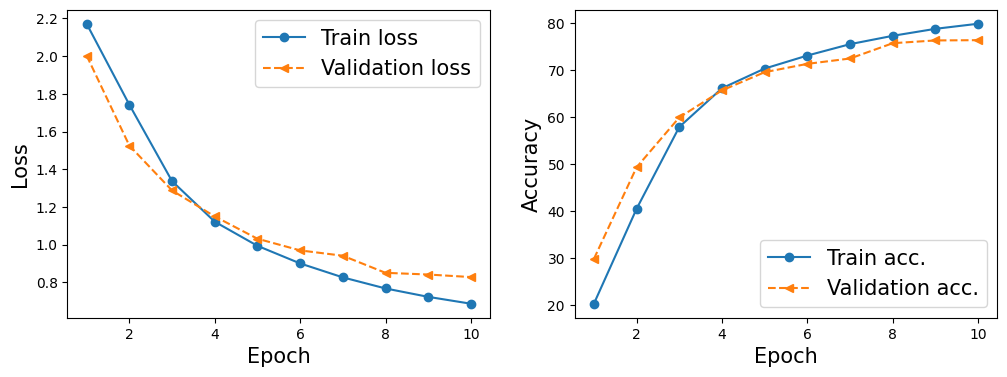

In [155]:
def plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist):
    x_arr = np.arange(len(loss_train_hist)) + 1

    with plt.ioff():
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, loss_train_hist, '-o', label='Train loss')
        ax.plot(x_arr, loss_val_hist, '--<', label='Validation loss')
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel('Loss', size=15)
        ax.legend(fontsize=15)
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, acc_train_hist, '-o', label='Train acc.')
        ax.plot(x_arr, acc_val_hist, '--<', label='Validation acc.')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel('Accuracy', size=15)
    return None

plot_history(history['train']['loss'], history['train']['accuracy'], history['val']['loss'], history['val']['accuracy'])
plt.show()

<span style="color:blue">
    Interpret the current status. Are you sattisfied with the result?
</span>

**Although the percentage is not as big as in the provided notebook, the accuracy seems to go up which is a good sign and more training can be performed.** 



## Task 2: Use the model for inference
Once the model has been trained, we want to use it to classify new images. Ideally, we have an appropriate way of visualizing the results.

### Task 2.1: Inference and visualization
<span style="color:blue">
    Now apply the model 
    <ul>
        <li>to a single image </li>
        <li>to 16 images of a batch provided by the test data loader</li>
    </ul>
    Then visually check the predictions vs. the actual classes for those 16 elements (be sure to arrange the images in a 4 x 4 grid when doing so)<br>
</span>

**Hints:**
* Compared to the material notebook, images now have a color channel. You need to adapt dimensions accordingly. When using single images as an input, you can use [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html) to get the correct dimension.
* The same applies to batches of images. Use [transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html) (or even easier: [permute](https://pytorch.org/docs/stable/generated/torch.permute.html#torch-permute)) to change dimensions.

In [157]:
classes = [str(i) for i in range(10)]


model.eval()  
with torch.no_grad():
    single_image, label = test_data[0]  
    single_image = single_image.unsqueeze(0).to(device)  
    output = model(single_image)  
    _, predicted = torch.max(output, 1) 

print(f"True Label: {classes[label]}")
print(f"Predicted Label: {classes[predicted.item()]}")


True Label: 5
Predicted Label: 5


In [159]:
model.eval()
with torch.no_grad():
    for i in range(16):
        image, label = test_data[i]  
        image = image.unsqueeze(0).to(device) 
        output = model(image)  
        _, predicted = torch.max(output, 1)  
        print(f"Image {i+1}: True Label = {classes[label]}, Predicted = {classes[predicted.item()]}")


Image 1: True Label = 5, Predicted = 5
Image 2: True Label = 2, Predicted = 2
Image 3: True Label = 1, Predicted = 1
Image 4: True Label = 0, Predicted = 0
Image 5: True Label = 6, Predicted = 6
Image 6: True Label = 1, Predicted = 1
Image 7: True Label = 9, Predicted = 5
Image 8: True Label = 1, Predicted = 1
Image 9: True Label = 1, Predicted = 1
Image 10: True Label = 8, Predicted = 8
Image 11: True Label = 3, Predicted = 1
Image 12: True Label = 6, Predicted = 5
Image 13: True Label = 5, Predicted = 5
Image 14: True Label = 1, Predicted = 1
Image 15: True Label = 4, Predicted = 4
Image 16: True Label = 4, Predicted = 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..-0.019607842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38039213..0.6156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.64705884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4352941..0.6392157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1607843..0.49803925].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73333335..0.12156868].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

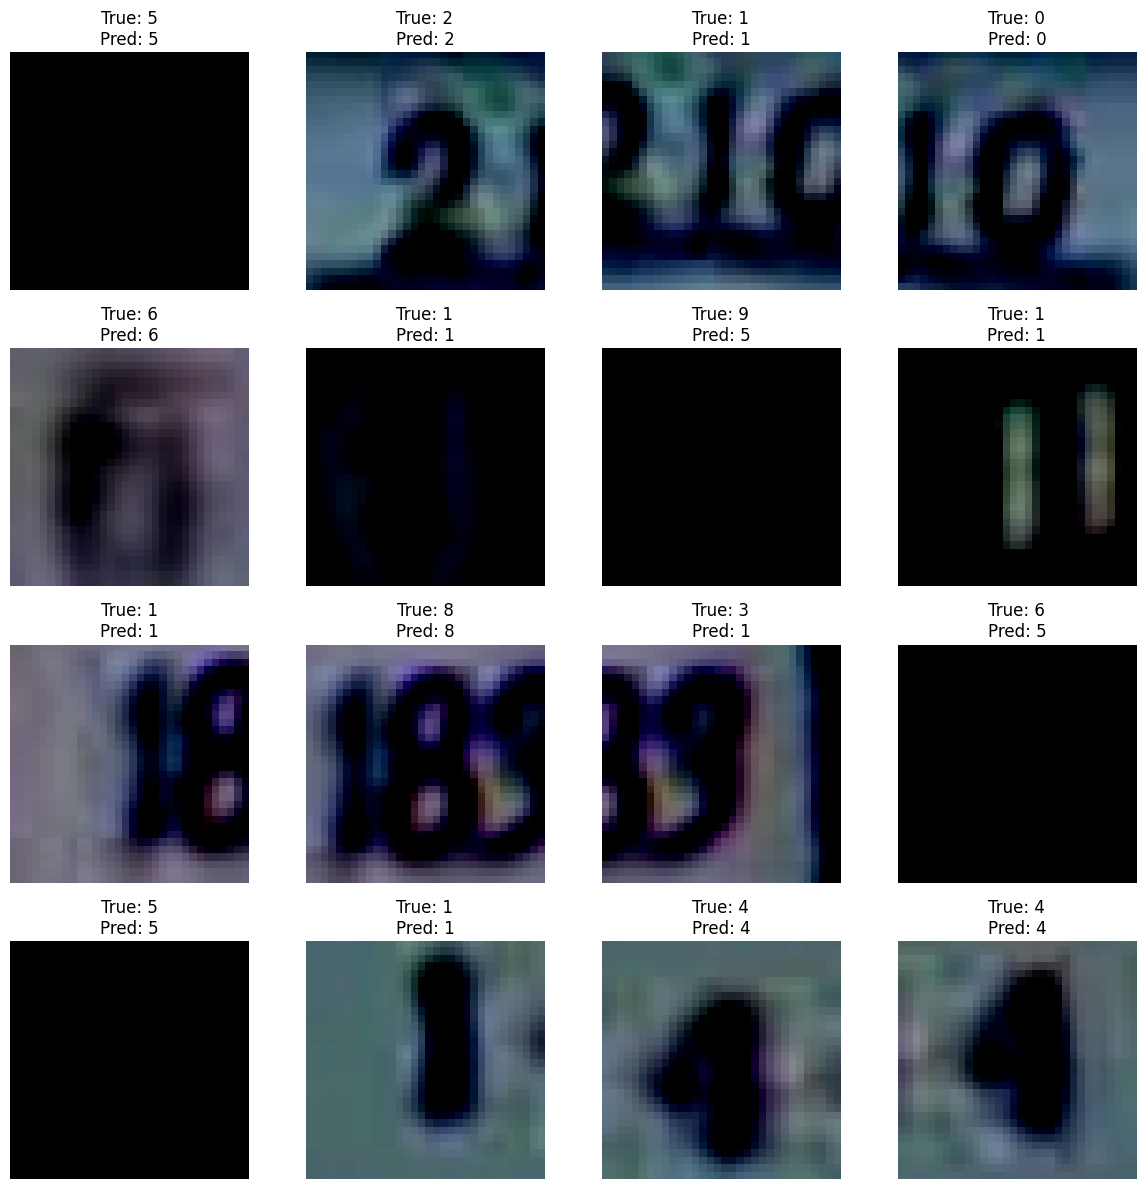

In [161]:
model.eval()
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  
with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        image, label = test_data[i]
        image_display = image.permute(1, 2, 0).cpu().numpy()  
        image = image.unsqueeze(0).to(device) 
        output = model(image)
        _, predicted = torch.max(output, 1)
        ax.imshow(image_display)
        ax.set_title(f"True: {classes[label]}\nPred: {classes[predicted.item()]}")
        ax.axis('off')  

plt.tight_layout()
plt.show()


---

### Task 2.2: Challenge - visualizing misclassifications
<span style="color:blue">
    Find all misclassifications and visualize some of them.
</span>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..-0.32549018].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.654902..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..-0.035294116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..0.56078434].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..0.654902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6627451..0.09019613].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137

Total Misclassified: 6164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8352941..-0.0745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.035294175].


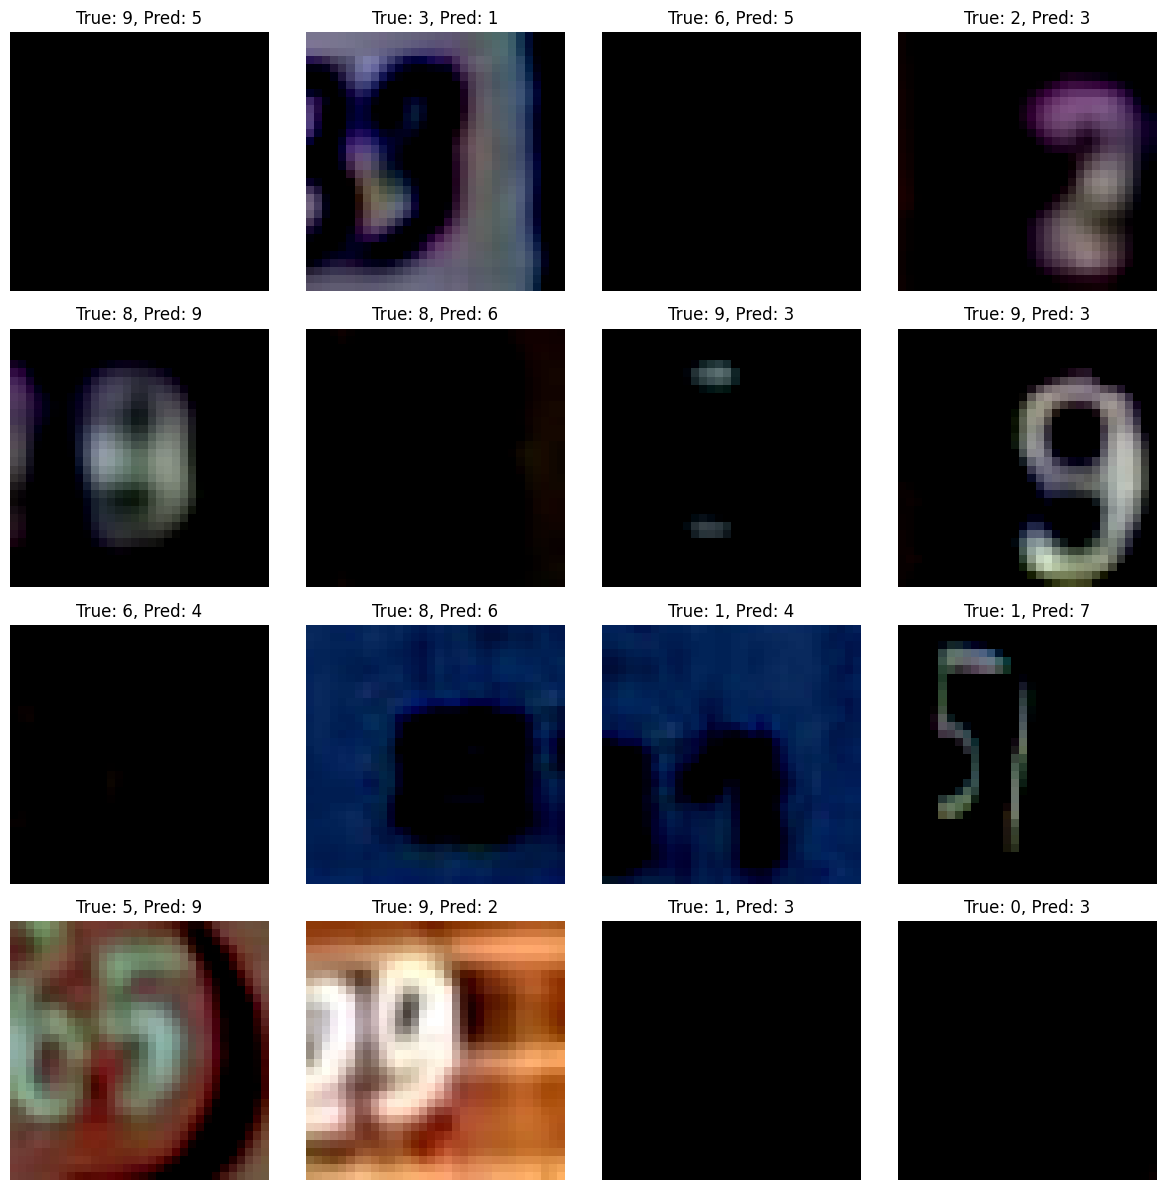

In [165]:
misclassified = [] 
model.eval()  
with torch.no_grad():
    for i in range(len(test_data)):
        image, label = test_data[i]  
        image_tensor = image.unsqueeze(0).to(device)  
        output = model(image_tensor)  
        _, predicted = torch.max(output, 1)  

        if predicted.item() != label:  
            misclassified.append((image, label, predicted.item())) 


print(f"Total Misclassified: {len(misclassified)}")

fig, axes = plt.subplots(4, 4, figsize=(12, 12))  
for i, ax in enumerate(axes.flat):
    if i >= len(misclassified):  
        break
    image, true_label, predicted_label = misclassified[i]
    image_display = image.permute(1, 2, 0).cpu().numpy()  

    ax.imshow(image_display)
    ax.set_title(f"True: {true_label}, Pred: {predicted_label}")
    ax.axis("off")  

plt.tight_layout()
plt.show()
